## **Simulated Point Labeling for Land Cover Classification**

#### **In this Notebook, I:**

* Use `pandas` and `OpenCV` to prepare the satellite images and masks from the `DeepGlobe` dataset, ensuring they are appropriately formatted for the model.

* Set up the `DeepLabV3Plus` model with ResNet 50 using the `segmentation_models_pytorch` library and explore its performance.

* Use NumPy to simulate `random point labels` on segmentation masks to handle partially labeled data effectively.

* Vary `sampling ratio` and `image resolution` to study their effects on the model's `Intersection over Union (IoU)` performance.

In [ ]:
!pip install segmentation-models-pytorch -q

In [ ]:
import os, cv2
import warnings
import torch
import numpy as np
import pandas as pd
import random, tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")

## **Data Loading**

Load the metadata.csv from the DeepGlobe dataset, filter for training images, and update their paths to ensure they are correctly accessed for processing.

In [ ]:
# Set the directory where the dataset is stored
DATA_DIR = '../input/deepglobe-land-cover-classification-dataset'

# Load metadata from CSV file and filter for training split
metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[metadata_df['split']=='train']

# Select necessary columns and update paths to be absolute
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))

# Display the updated DataFrame
metadata_df

,image_id,sat_image_path,mask_path
0,100694,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...
1,102122,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...
2,10233,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...
3,103665,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...
4,103730,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...
...,...,...,...
798,992507,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...
799,994520,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...
800,995492,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...
801,997521,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...


## **Dataset Shuffling and Splitting**

Shuffle the dataset and split it into training and validation sets with an `80/20` distribution, essential for model training and evaluation.

In [ ]:
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Perform 80/20 split for train / val on the reduced dataset
valid_df = metadata_df.sample(frac=0.25, random_state=42)
train_df = metadata_df.drop(valid_df.index)

# Output the lengths of the train and validation sets
len(train_df), len(valid_df)

(602, 201)

## **Class Label Mapping**

Create a mapping from class indices to their corresponding RGB values, essential for image segmentation tasks, and includes a default label `[-1,-1,-1]` for undefined classes.

In [ ]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))

# Get class names
class_names = class_dict['name'].tolist()

# Get class RGB values
class_rgb_values = class_dict[['r', 'g', 'b']].values.tolist()

# Initialize a dictionary to map class indices to RGB color values
label_map = {}

# Populate the label_map with RGB values from the class_dict DataFrame
for index, row in class_dict.iterrows():
    label_map[index] = [row["r"], row["g"], row["b"]]

# Add a default label for undefined areas with RGB as [-1, -1, -1]
label_map[-1] = [-1, -1, -1]

# Create lists for DataFrame construction
class_labels = list(label_map.keys())  # Extract class labels directly from the label_map keys
rgb_values = list(label_map.values())  # Extract RGB values directly from the label_map values

# Create a DataFrame from the lists
classes_df = pd.DataFrame({
    'Class Name': class_names + ['unlabeled'],  # Adding 'undefined' for the manually added class label
    'RGB Value': rgb_values,
    'Class Label': class_labels
})

# Display the DataFrame
classes_df

,Class Name,RGB Value,Class Label
0,urban_land,"[0, 255, 255]",0
1,agriculture_land,"[255, 255, 0]",1
2,rangeland,"[255, 0, 255]",2
3,forest_land,"[0, 255, 0]",3
4,water,"[0, 0, 255]",4
5,barren_land,"[255, 255, 255]",5
6,unknown,"[0, 0, 0]",6
7,unlabeled,"[-1, -1, -1]",-1


## **Helper Functions**
* **Visualize Function:** This function displays multiple images in a single row for comparative analysis. It calculates the number of images, sets up a figure, and places each image in a subplot without axis ticks for clarity. The titles are dynamically formatted from the keyword arguments, enhancing the presentation for various image processing stages.

* **Colour Code Segmentation Function:** This function converts a segmentation mask into a color-coded image. It initializes a blank RGB image matching the mask's size, creates an inverse mapping from labels to RGB values, and applies these colors directly to the mask. This visual transformation helps distinguish different classes in the segmentation output clearly.

* **Random Sample Points Function:** Aimed at simulating partial labeling, this function calculates the total number of points to sample from the mask based on a specified percentage. It selects these points randomly, initializes a new mask with unlabeled points marked as -1, and updates it with values from the original mask at the selected positions, creating a sparsely labeled mask.

In [ ]:
# Side by Side Visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(10,4))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=10)
        plt.imshow(image)
    plt.show()

# Perform colour coding on the labelled Image
def colour_code_segmentation(mask, label_map):
    mask = mask.squeeze()

    # Create an empty array with the same height and width as the mask and 3 channels for the RGB colors
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    # Invert the label_map to map from labels to colors
    inverse_label_map = {tuple(v): k for k, v in label_map.items()}

    for color, label in inverse_label_map.items():
        color_array = np.array(color, dtype=np.int32)
        color_mask[mask == label] = color_array

    return color_mask

# Random Point labelling Function
def random_sample_points(mask, percentage):
    total_points = mask.shape[0] * mask.shape[1]
    num_points = int(total_points * percentage)

    # Generate a flat index array and select a subset of indices
    indices = np.arange(total_points)
    selected_indices = np.random.choice(indices, num_points, replace=False)

    # Initialize point_mask with -1 for unselected points
    point_mask = -np.ones_like(mask, dtype='int')

    # Convert flat indices to 2D indices
    x, y = np.unravel_index(selected_indices, mask.shape[:2])

    # Assign original mask values at the selected points
    point_mask[x, y] = mask[x, y]

    return point_mask

## **Dataset Class**

In PyTorch, creating a custom dataset class with an `__getitem__` method is crucial for efficiently managing data loading and preprocessing. This approach allows each dataset instance to be retrieved and processed individually on-the-fly, which is essential for handling large datasets that don't fit entirely in memory. The `__getitem__` method ensures that each data point can be dynamically transformed (e.g., through augmentation, resizing) during training. Moreover, this method integrates seamlessly with PyTorch's DataLoader to provide easy batching, shuffling, and parallel data loading.

The steps performed for each image are:

* **Image Loading:** Reading and converting images and masks into RGB format using OpenCV.
* **Resizing:** Adjusting the dimensions of both images and masks to the specified size.
* **Simulated Point Labeling:** Applies simulated point labeling to the masks, selecting a subset of mask points based on the sampling_ratio, which mimics scenarios with partial labels.
* **Class Labeling**: Converting the color-coded mask into a numerical label map using the predefined color-to-label mapping.
* **Preprocessing:** Appling any additional preprocessing steps (if provided), such as normalization specific to the training model's requirements.

In [ ]:
class LandCoverDataset(torch.utils.data.Dataset):

    def __init__(self,df,label_map,preprocessing=None,image_size=256,sampling_ratio=0.65):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()

        self.label_map = label_map
        self.preprocessing = preprocessing
        self.image_size = image_size
        self.sampling_ratio = sampling_ratio

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # Resize images and masks by half
        new_width = self.image_size
        new_height = self.image_size
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, (new_width, new_height), interpolation=cv2.INTER_NEAREST)

        # Apply Simulated Point Labelling
        point_mask = random_sample_points(mask, self.sampling_ratio)

        orig_mask = self.colormap_to_labelmap(mask)
        point_mask = self.colormap_to_labelmap(point_mask)

        orig_mask = orig_mask[:, :, np.newaxis]
        point_mask = point_mask[:, :, np.newaxis]

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=point_mask)
            image, point_mask = sample['image'], sample['mask']

        return image, (point_mask,orig_mask)

    def colormap_to_labelmap(self, mask):
        label_image = np.zeros_like(mask[:,:,0], dtype=np.int32)

        for label, color in self.label_map.items():
            color_array = np.array(color)
            mask_condition = np.all(mask == color_array, axis=-1)
            label_image[mask_condition] = label

        return label_image.astype(np.float32)

    def __len__(self):
        # return length of
        return len(self.image_paths)

## **Focal Loss and Partial Cross-Entropy Loss**

<br>

1. #### **Focal Loss:**
Focal loss is a modification of the standard cross-entropy loss designed to address class imbalance in classification problems. The equation for focal loss is:

 $$\large FL = -\alpha_t (1 - p_t)^\gamma \log(p_t) $$
where:
 * $(p_t)$ is the model's estimated probability for the class with label t
 * $(\alpha_t)$ is a weighting factor to balance class frequencies (often omitted or set to 1)
 * $(\gamma)$ is the focusing parameter that controls how much to down-weight easy examples (correctly classified with high confidence). A higher gamma focuses more on hard examples.

<br>

2. #### **Focal Loss vs. Cross-Entropy Loss:**
When $\large(\gamma = 0)$ and $\large(\alpha_t = 1)$, the focal loss equation reduces to the standard cross-entropy loss:

 $$\large CE = -\log(p_t)$$

<br>

3. #### **Partial Cross-Entropy Loss (Modified Focal Loss):**
This notebook implements a modified version of focal loss that incorporates the concept of `partial labels`. This is designed for scenarios where some samples in your dataset might have missing or incomplete labels.

 **Masking:** The code introduces a masking mechanism to filter out samples with missing labels (indicated by -1 in the target tensor). Only samples with valid labels contribute to the loss calculation.

 **Adjusted Equation:** The modified equation for this partial cross-entropy loss is:

 $$\large pCE = \frac{\sum (\text{Focal loss}(pre, GT) \times \text{MASK}_{labeled})}{\sum \text{MASK}_{labeled}}$$
where:
 * $ pCE$: Partial Cross-Entropy Loss
 * $\text{Focal loss}(pre, GT)$: The focal loss computed between the model's predictions (pre) and the ground truth labels (GT).
 * $\text{MASK}_{labeled}$: A binary mask indicating whether a label is valid `1` or missing `-1`.
 * $\sum \text{MASK}_{labeled}$: The summation of the elements in $\text{MASK}_{labeled}$, which counts the number of valid labels in the dataset. This sum acts as a normalization factor in the calculation of the partial Cross-Entropy Loss.

In [ ]:
class PartialCrossEntropyLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, reduction='mean'):
        super(PartialCrossEntropyLoss, self).__init__()
        self.__name__ = 'PartialCrossEntropyLoss'
        self.reduction = reduction
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int, torch.LongTensor)):
            self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha)

    def forward(self, input, target):

        target = target.squeeze().long()

        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)  # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))  # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        # Mask out -1 values in the target
        labelled_mask = target != -1
        input = input[labelled_mask.view(-1), :]  # Adjust input to only consider valid targets
        target = target[labelled_mask.view(-1), :]  # Filter out -1 in targets

        # Calculate the log probability of the correct class.
        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = torch.exp(logpt)

        # Apply the alpha weighting if it's provided.
        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * at # Scale the log probabilities by the alpha values.

        # Calculate the focal loss.
        loss = -1 * (1 - pt) ** self.gamma * logpt

        # Aggregate the loss based on the specified reduction method.
        if self.reduction == "none":
            return loss
        elif self.reduction == "mean":
            return loss.mean() # Dividing by Sum of Labelled Mask
        elif self.reduction == "sum":
            return loss.sum()

In [ ]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

## **Intersection over Union (IoU)**
This metric is crucial for assessing how well the predicted segmentation maps overlap with the ground truth.

The steps involved are:

* **Convert Logits to Probabilities:** The function starts by converting the output logits from the model to probabilities using the torch.softmax function. This step is necessary because the raw outputs from a neural network are not directly interpretable as probabilities.

* **Determine Predicted Labels:** It then identifies the predicted labels by taking the argmax of the probabilities across the channel dimension, which corresponds to class predictions in a segmentation task.

* **Handling Label Formats:** The true labels are squeezed to remove any unnecessary dimensions to match the format of the predicted labels.

* **One-Hot Encoding:** Both the predicted and true labels are converted into one-hot encoded formats. One-hot encoding transforms categorical labels into vectors of 0s and 1 where the index of 1 corresponds to the class label. This format is necessary for computing intersections and unions across class labels.

* **Compute Intersection and Union:**

    * **Intersection:** The element-wise multiplication of the one-hot encoded predicted and true labels gives the intersection - areas where the predicted class and the true class agree.
    * **Union:** The element-wise addition of the one-hot encoded labels minus their intersection gives the union - areas covered by either the predicted class or the true class.


* **Calculate IoU:** The IoU for each class is calculated by dividing the intersection by the union. A small constant (1e-6) is added to the denominator to prevent division by zero.

* **Average IoU:** Finally, the mean IoU across all classes is computed to provide a single performance metric that summarizes how well the model's predictions conform to the true labels across all classes.

In [ ]:
def calculate_iou(outputs, masks):

    # Convert logits to probabilities
    probabilities = torch.softmax(outputs, dim=1)

    # Convert probabilities to predicted labels
    pred_labels = torch.argmax(probabilities, dim=1)  # (batch_size, H, W)
    true_labels = masks.squeeze().long()  # (batch_size, H, W)

    num_classes = outputs.shape[1]
    batch_size = outputs.shape[0]

    # Create one-hot versions of predicted and true labels
    pred_one_hot = F.one_hot(pred_labels, num_classes).permute(0, 3, 1, 2).float()
    true_one_hot = F.one_hot(true_labels, num_classes).permute(0, 3, 1, 2).float()

    # Calculate intersection and union
    intersection = (pred_one_hot * true_one_hot).sum(dim=(0, 2, 3))
    union = (pred_one_hot + true_one_hot - pred_one_hot * true_one_hot).sum(dim=(0, 2, 3))

    # Avoid zero division and calculate IoU
    iou = (intersection + 1e-6) / (union + 1e-6)

    # Average IoU across all classes
    mean_iou = iou.mean()
    return mean_iou

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, DEVICE):
    # Initialize accumulators for loss and IoU for the epoch
    train_loss = 0.0
    train_iou = 0.0

    # Loop through each batch from the data loader
    for batch_index, batch in enumerate(train_loader):
        images, masks_tuple = batch

        # Move images and masks to the specified DEVICE (GPU or CPU)
        images = images.to(DEVICE)
        point_masks = masks_tuple[0].to(DEVICE) # Point masks for loss calculation
        orig_masks = masks_tuple[1].to(DEVICE)  # Original masks for IoU calculation

        # Reset gradients to zero before starting backpropagation
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing images to the model
        outputs = model(images)

        # Compute loss based on model's output and the target point masks
        loss = loss_fn(outputs, point_masks)

        # Calculate the Intersection over Union (IoU) using model outputs and the original masks
        iou = calculate_iou(outputs, orig_masks)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Accumulate the loss and IoU for this batch
        train_loss += loss.item()
        train_iou += iou.item()

    # Calculate the average loss and IoU for the epoch
    train_loss /= len(train_loader)
    train_iou /= len(train_loader)
    return train_loss, train_iou

In [ ]:
def validate(model, valid_loader, loss_fn, DEVICE):
    # Initialize accumulators for validation loss and IoU
    valid_loss = 0.0
    valid_iou = 0.0

    # Disable gradient computation since we are only evaluating and not training
    with torch.no_grad():

        # Iterate through each batch in the validation data loader
        for batch in valid_loader:
            images, masks_tuple = batch

            # Move images and masks to the specified computing device (GPU or CPU)
            images = images.to(DEVICE)

            point_masks = masks_tuple[0].to(DEVICE) # Point masks for calculating the loss
            orig_masks = masks_tuple[1].to(DEVICE) # Original masks for calculating the IoU

            # Forward pass: compute the model's predictions for the images
            outputs = model(images)

            # Compute the loss using the predicted outputs and the provided point masks
            loss = loss_fn(outputs, point_masks)

            # Accumulate the computed loss
            valid_loss += loss.item()

            # Calculate the Intersection over Union (IoU) using the predicted outputs and the original masks
            iou = calculate_iou(outputs, orig_masks)

            # Accumulate the computed IoU
            valid_iou += iou.item()

    # Compute the average loss and IoU across all batches in the validation set
    valid_loss /= len(valid_loader)
    valid_iou /= len(valid_loader)
    return valid_loss, valid_iou

## **Experiment Execution**

This function orchestrates the setup, training, and validation of a semantic segmentation model using the DeepLabV3Plus architecture. It allows for dynamic experimentation with different sampling ratios and image sizes to study their impacts on model performance.

In [ ]:
def run_experiment(sampling_ratio, image_size, num_epochs=5):
    # Log the experiment details
    print(f"Running experiment with ({sampling_ratio*100}%) sampling, image size ({image_size}))")

    # Set up the computing device based on availability of CUDA
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model with specified encoder and pretrained weights
    model = smp.DeepLabV3Plus(encoder_name = 'resnet50',encoder_weights = 'imagenet',classes=len(class_names),activation=None).to(DEVICE)

    # Retrieve the preprocessing function for the selected model from segmentation models pytorch library
    preprocessing_fn = smp.encoders.get_preprocessing_fn('resnet50', 'imagenet')

    # Initialize the custom loss function
    loss_fn = PartialCrossEntropyLoss().to(DEVICE)

    # Set up the optimizer with a specified learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

    # Prepare training dataset with given specifications
    train_dataset = LandCoverDataset(train_df,
                                     label_map,
                                     preprocessing=get_preprocessing(preprocessing_fn),
                                     image_size=image_size,
                                     sampling_ratio=sampling_ratio)

    # Prepare validation dataset similarly
    valid_dataset = LandCoverDataset(valid_df,
                                     label_map,
                                     preprocessing=get_preprocessing(preprocessing_fn),
                                     image_size=image_size,
                                     sampling_ratio=sampling_ratio)

    # DataLoader objects to load data in batches with shuffling for Training set
    train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, worker_init_fn=np.random.seed(42))
    valid_loader = DataLoader(valid_dataset, batch_size=3, shuffle=False)

    # Execute training and validation for the specified number of epochs
    for epoch in range(num_epochs):
        print(f"###### Epoch {epoch + 1}/{num_epochs}")
        model.train()
        train_loss, train_iou = train_one_epoch(model, train_loader, loss_fn, optimizer, DEVICE)
        model.eval()
        valid_loss, valid_iou = validate(model, valid_loader, loss_fn, DEVICE)
        print(f"### Train IoU: {train_iou:.4f}, Valid IoU: {valid_iou:.4f}")

    # Save the trained model
    torch.save(model, f'./{sampling_ratio}_{image_size}.pth')
    return train_iou, valid_iou

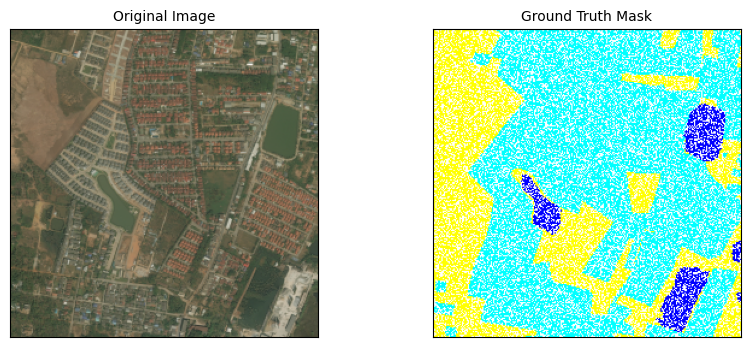

In [ ]:
# Visualizing a Image and its GT Mask
image, (point_mask,orig_mask) = LandCoverDataset(train_df, label_map).__getitem__(2)

visualize(original_image = image, ground_truth_mask = colour_code_segmentation(point_mask, label_map))

In [ ]:
sampling_ratios = [0.60,0.90]
image_sizes = [512,1024]

results = []

for sampling_ratio in sampling_ratios:
    for image_size in image_sizes:
        train_iou, valid_iou = run_experiment(sampling_ratio, image_size)
        results.append({
            "Sampling Percentage": sampling_ratio,
            "Image Resolution": image_size,
            "Train IoU": train_iou,
            "Valid IoU": valid_iou
        })

# Convert results list to DataFrame
results_df = pd.DataFrame(results)

# Saving Results in a CSV file
results_df.to_csv("experiment_results.csv", index=False)

Running experiment with (60.0%) sampling, image size (512))


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 225MB/s] 


###### Epoch 1/5
### Train IoU: 0.1328, Valid IoU: 0.2030
###### Epoch 2/5
### Train IoU: 0.2307, Valid IoU: 0.2476
###### Epoch 3/5
### Train IoU: 0.2925, Valid IoU: 0.3201
###### Epoch 4/5
### Train IoU: 0.3212, Valid IoU: 0.3818
###### Epoch 5/5
### Train IoU: 0.3701, Valid IoU: 0.4417
Running experiment with (60.0%) sampling, image size (1024))
###### Epoch 1/5
### Train IoU: 0.0987, Valid IoU: 0.2189
###### Epoch 2/5
### Train IoU: 0.2625, Valid IoU: 0.3174
###### Epoch 3/5
### Train IoU: 0.3055, Valid IoU: 0.3423
###### Epoch 4/5
### Train IoU: 0.3396, Valid IoU: 0.4071
###### Epoch 5/5
### Train IoU: 0.3500, Valid IoU: 0.4448
Running experiment with (90.0%) sampling, image size (512))
###### Epoch 1/5
### Train IoU: 0.1346, Valid IoU: 0.1995
###### Epoch 2/5
### Train IoU: 0.2378, Valid IoU: 0.2955
###### Epoch 3/5
### Train IoU: 0.2727, Valid IoU: 0.3523
###### Epoch 4/5
### Train IoU: 0.3178, Valid IoU: 0.3904
###### Epoch 5/5
### Train IoU: 0.3937, Valid IoU: 0.3881
Running e

In [ ]:
# Display the results in a pivot table for better visualization
pivot_table = results_df.pivot_table(
    index=["Image Resolution"],
    columns="Sampling Percentage",
    values="Valid IoU",
    aggfunc='mean'  # Aggregate function if there are multiple entries for the same combination
)

print("\nFinal Validation IOUs Grid:")
pivot_table


Final Validation IOUs Grid:


Sampling Percentage,0.6,0.9
Image Resolution,,
512,0.441731,0.388095
1024,0.444776,0.433720


In [ ]:
max_iou = pivot_table.max().max()

# Find the (Image Size, Model Size) and Sampling Percentage where the maximum IoU occurs
max_iou_location = pd.DataFrame(pivot_table.unstack()).reset_index()
max_row = results_df[results_df['Valid IoU'] == max_iou]

best_img_res = max_row["Image Resolution"].iloc[0]
best_sam_per = max_row["Sampling Percentage"].iloc[0]

print("Maximum IoU Details:")
print("\nBest Image Resilution = ", best_img_res)
print("\nBest Sampling Percentage = ", best_sam_per)

Maximum IoU Details:

Best Image Resilution =  1024

Best Sampling Percentage =  0.6


In [ ]:
# Load Best Model

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_model = torch.load(f'./{best_sam_per}_{best_img_res}.pth', map_location=DEVICE)
print('Loaded Best Model from this run.')

Loaded Best Model from this run.


## **Visualizing Test Results**

In [ ]:
test_dataset = LandCoverDataset(
    valid_df,
    label_map,
    preprocessing = get_preprocessing(smp.encoders.get_preprocessing_fn('resnet50', 'imagenet')),
    image_size=best_img_res,
    sampling_ratio=best_sam_per,
)

# Test dataset for visualization (without preprocessing)
test_dataset_vis = LandCoverDataset(
    valid_df,
    label_map,
    image_size=best_img_res,
    sampling_ratio=best_sam_per,
)

In [ ]:
for idx in range(len(test_dataset)):

    image, (pm, om) = test_dataset[idx]
    image_vis, (pm2,om2) = test_dataset_vis[idx]
    image_vis = image_vis.astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = F.softmax(pred_mask,dim=1)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()

    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))

    # Get prediction channel corresponding to foreground
    pred_urban_land_heatmap = pred_mask[:,:,class_names.index('urban_land')]
    pred_mask = colour_code_segmentation(np.argmax(pred_mask, axis = -1), label_map)

    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = colour_code_segmentation(om2, label_map)

    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        pred_urban_land_heatmap = pred_urban_land_heatmap
    )